# Look at the Big picture
## Frame the Problem
Is it supervised, unsupervised, or Reinforcement Learning?Is it a classification task, a regression task, or something else? Should you use batch learning or online learning techniques?

A sequence of data processing components is called a data **Pipelines**.

## Select a Performance Measure
- Root Mean Square Error(RMSE)
- Mean Absolute Error(MAE)

# Dive into Codes now
## Look at the data structure

In [1]:
import pandas as pd

In [2]:
housing = pd.read_csv('datasets/housing/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


another quick way to get a feel of the type of dta you are dealing with is to plot a histogram for each numerical attribute.

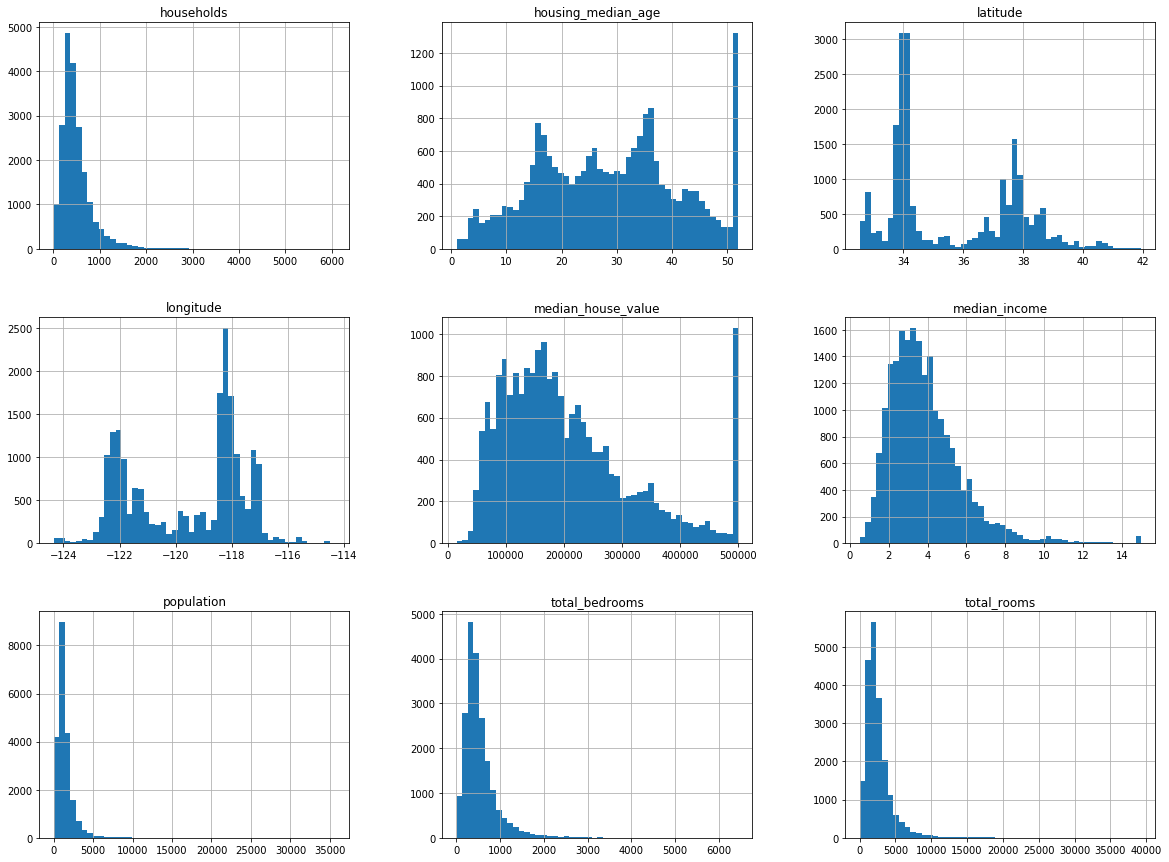

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize = (20,15))
plt.show()

Notice a few things in these histograms:
1. These attributes have very different scales.
2. Many histograms are **tail heavy**: they extend much farther to the right of the median than to the left. **This may make it a bit harder for some Machine Learning algorithms to detect patterns**. We will try transforming these attributes later on to have more bell-shaped distributions.

### Create a Test Set
If you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of ML model. You may launch a system that will not perform as well as expected. This is called **data snooping** bias.(数据透视偏差 是指在基于先前得到的实证经验后对历史数据进行分析后所得到的偏差。)

In [7]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set),"train +", len(test_set), "test", )

16512 train + 4128 test


This works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, your ML algorithm will get to see the whole dataset, which is what you want to avoid.

One option is to save the test set on the first run and then load it in subsequent runs. Another option is to set the random number generator's seed before calling `np.random.permutation()`. But both will break next time you fetch an updated dataset.

A common solution is to use each instance's identifier to decide whether or not it should go in the test set.

Here is a possible implementation:

In [11]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash= hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID.

In [12]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [13]:
# Use sklearn
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Stratified sampling(分层采样）
The population is divided into homogeneous subgroups called **strate**, and then right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

Suppose experts said that the median income is very important attribute to predict median housing prices. You may want to ensure that test set is representative of teh various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute.

let's look at the median income histogram more closely.

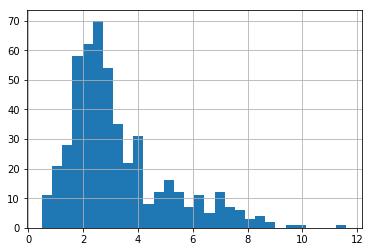

In [19]:
housing.median_income.iloc[:500].hist(bins=30)

It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum's importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. 

The following code creates an income category attribute by dividing the median income by 1.5(to limit the number of income categories), and rounding up using `ceil`, and then merging all the categories greater than 5 into category 5;

In [20]:
housing["income_cat"] = np.ceil(housing.median_income / 1.5)
housing['income_cat'].where(housing['income_cat']<5,5.0, inplace=True)

Do stratified  sampling based on the income category.

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state= 42)
for train_index, test_index in split.split(housing, housing.income_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [23]:
housing.income_cat.value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Remove the `income_cat` attribute so the data is back to its original state:

In [26]:
for set in (strat_test_set, strat_train_set):
    set.drop(['income_cat'], axis = 1, inplace=True)

## Discover and Visualize the Data to Gain Insights
First, make sure your are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast.

In [27]:
housing = strat_train_set.copy()

### Visualizing Geographical Data


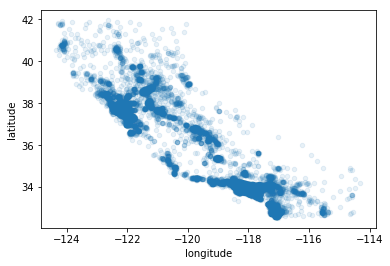

In [29]:
housing.plot(kind='scatter', x="longitude", y="latitude", alpha = 0.1)

Now we look at the housing prices. The radius of each circle represents the district's population, and the color represents the price.

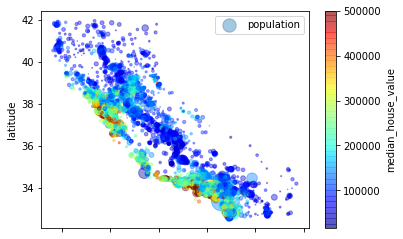

In [30]:
housing.plot(kind="scatter", x='longitude', y='latitude', alpha = 0.4,
            s = housing.population/100, label = 'population',
            c = 'median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()